In [99]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import re
import seaborn as sns
import time
import lightgbm as lgbm
from pathlib import Path
import pickle
from catboost import CatBoostClassifier, cv, Pool
import scikitplot as skplt
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, tpe, partial

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import datetime as dt
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, model_selection, svm, datasets, tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import plot_confusion_matrix, auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, Binarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import json
from io import StringIO

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima

from tbats import TBATS, BATS

# Loading and cleaning login data

In [2]:
with open('logins.json') as f:
  data = json.load(f)
logins = pd.DataFrame(data)

logins.reset_index
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins['login_time'] = logins['login_time'].dt.floor('T')
logins = logins.set_index('login_time')
logins['num_logins']=1
logins = logins.resample('1T').sum()



logins.describe()

,num_logins
count,146806.000000
mean,0.634456
std,0.951275
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,10.000000


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146806 entries, 1970-01-01 20:12:00 to 1970-04-13 18:57:00
Freq: T
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   num_logins  146806 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [4]:
logins.head()

,num_logins
login_time,
1970-01-01 20:12:00,1
1970-01-01 20:13:00,1
1970-01-01 20:14:00,0
1970-01-01 20:15:00,0
1970-01-01 20:16:00,3


In [5]:
logins.tail()

,num_logins
login_time,
1970-04-13 18:53:00,0
1970-04-13 18:54:00,2
1970-04-13 18:55:00,0
1970-04-13 18:56:00,0
1970-04-13 18:57:00,1


# Resampling logins to 15min intervals

### A single day at 15min intervals

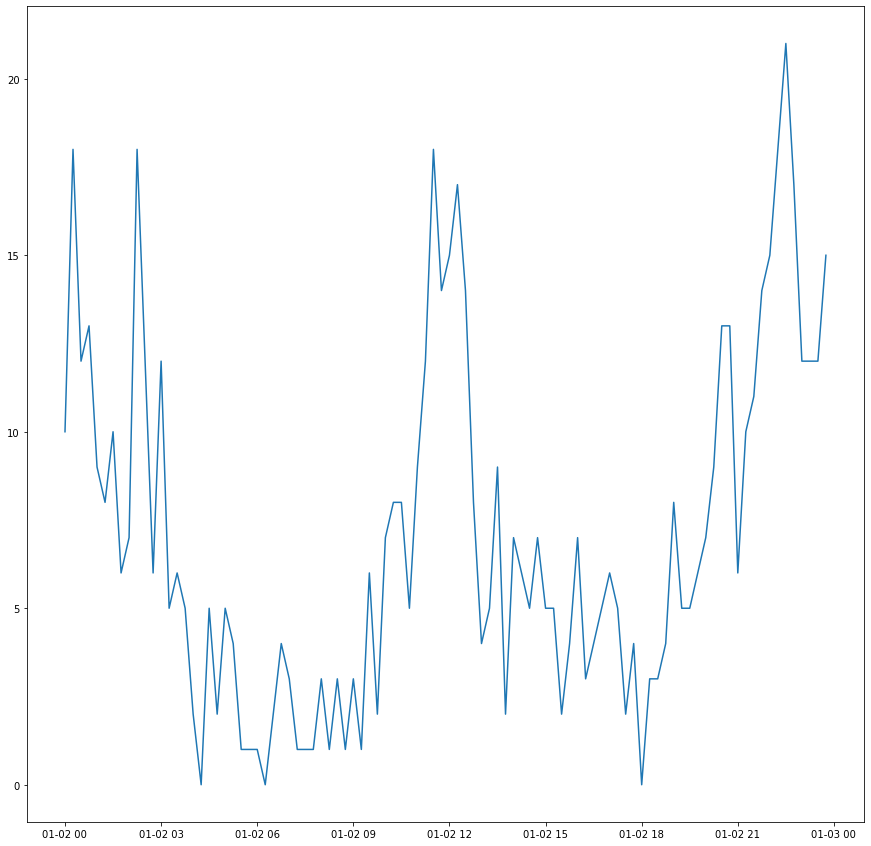

In [6]:
logins_15min = logins.resample('15T').sum()

plt.figure(figsize=(15,15))
plt.plot(logins_15min.loc['1970-01-02'])
plt.show()

### A single week at 15min intervals

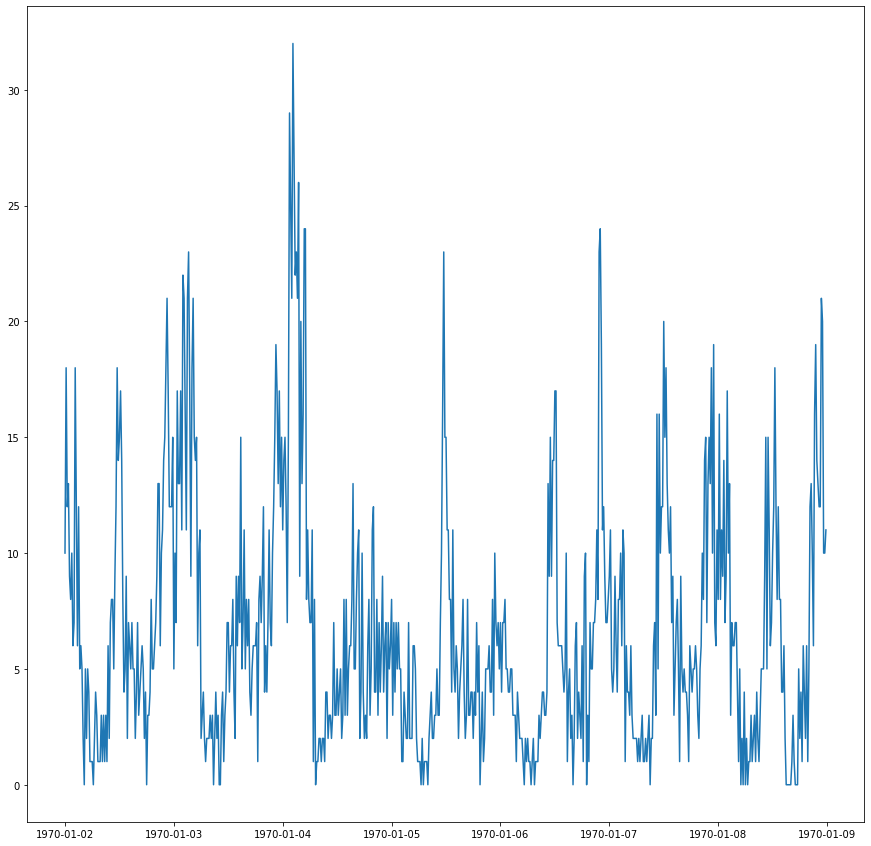

In [7]:
plt.figure(figsize=(15,15))
plt.plot(logins_15min.loc['1970-01-02':'1970-01-08'])
plt.show()

# ADFuller test has element 1 < .05, therefore logins is fairly stationary; it won't need differencing

In [8]:
adfuller(logins_15min)

(-10.337954309060441,
 2.7323966542230642e-18,
 38,
 9749,
 {'1%': -3.431020942932955,
  '5%': -2.8618365160244372,
  '10%': -2.5669278303551253},
 56368.34584451129)

# Seasonal decomp of logins by day

<Figure size 432x288 with 0 Axes>

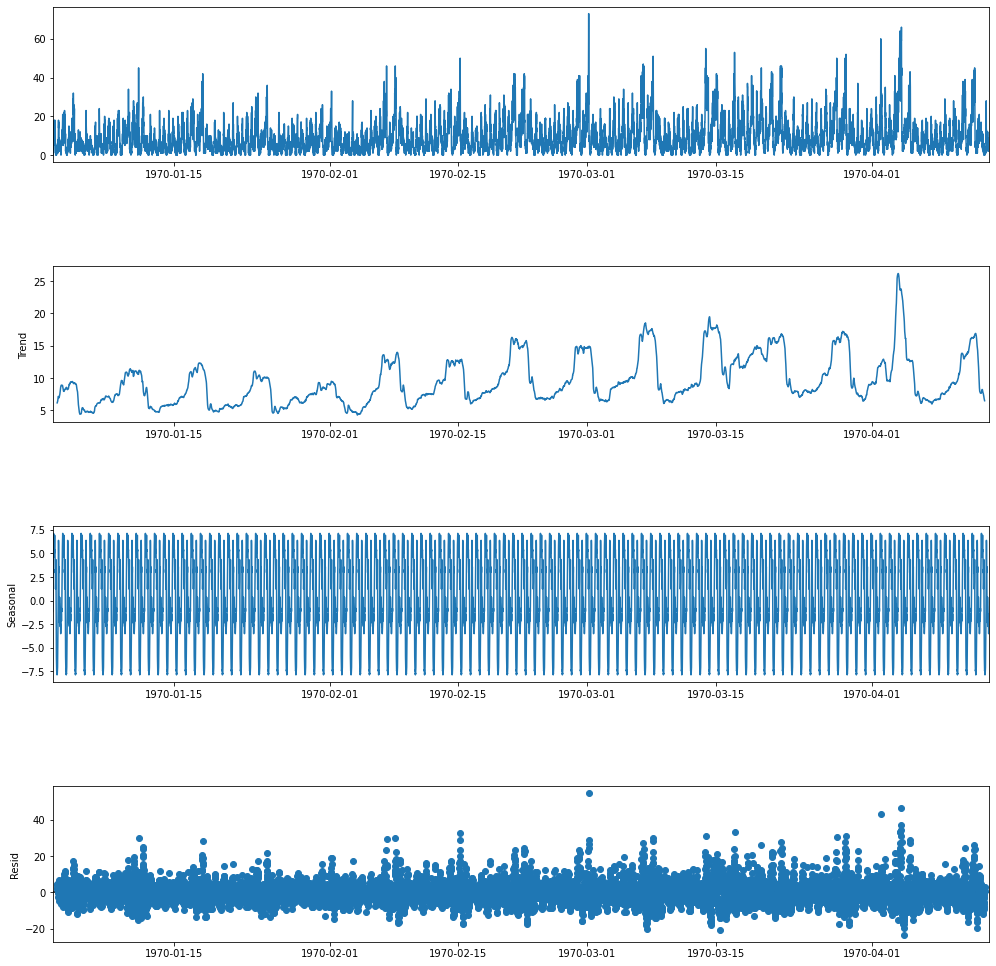

In [9]:
decomp_results = seasonal_decompose(logins_15min, freq=96)
fig = plt.figure()
fig = decomp_results.plot()
fig.set_size_inches(15, 15)

# Seasonal decomp of logins by week

<Figure size 432x288 with 0 Axes>

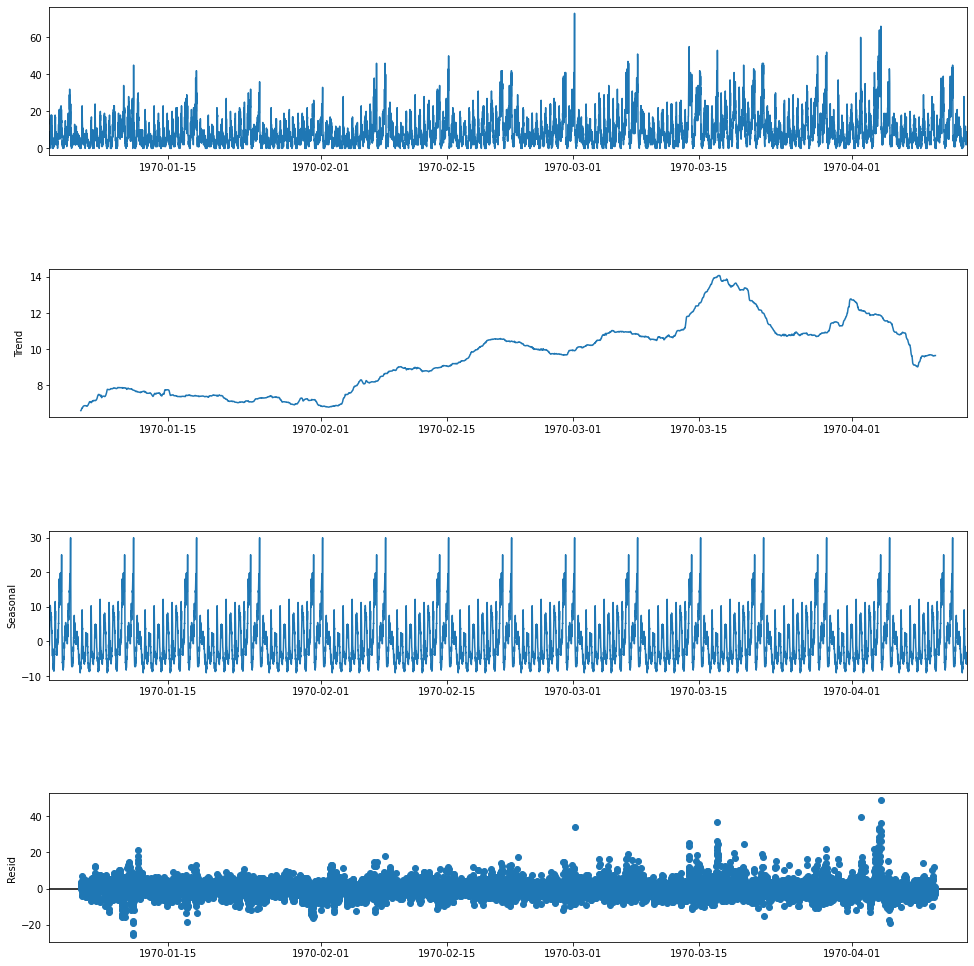

In [10]:
decomp_results = seasonal_decompose(logins_15min, freq=96*7)
fig = plt.figure()
fig = decomp_results.plot()
fig.set_size_inches(15, 15)

# The ACF shows daily seasonality (15min*96=1day)

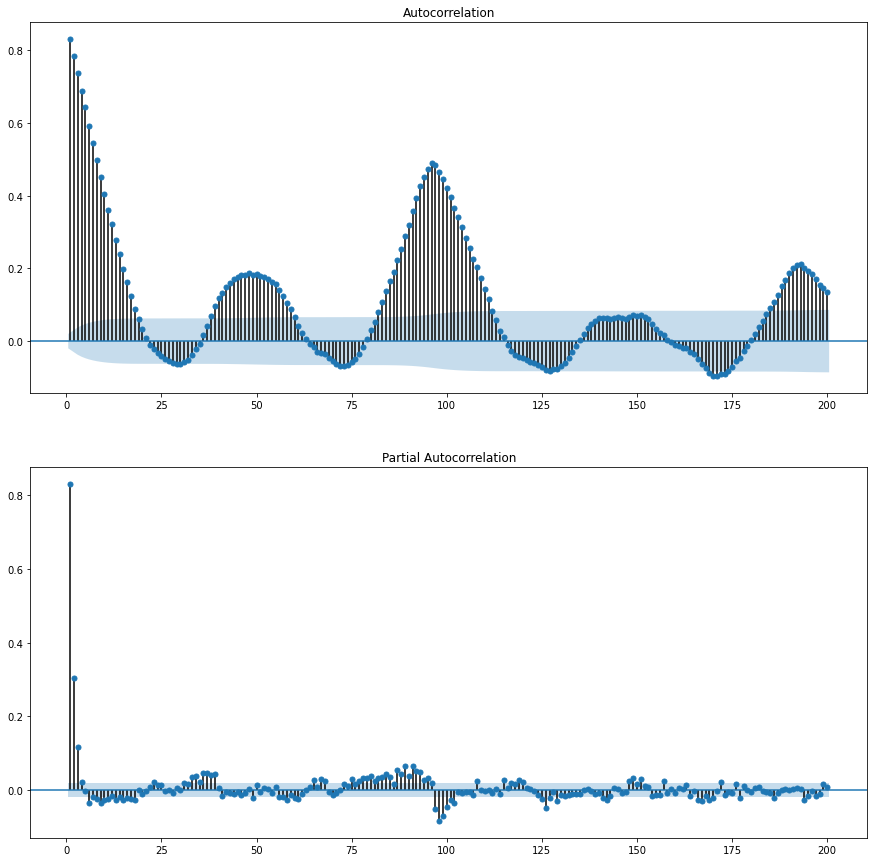

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,15))
plot_acf(logins_15min, lags=200, zero=False, ax=ax1)
plot_pacf(logins_15min, lags=200, zero=False, ax=ax2)
plt.show()

### After differencing by 96 (a single day), you can see there's weekly seasonality.

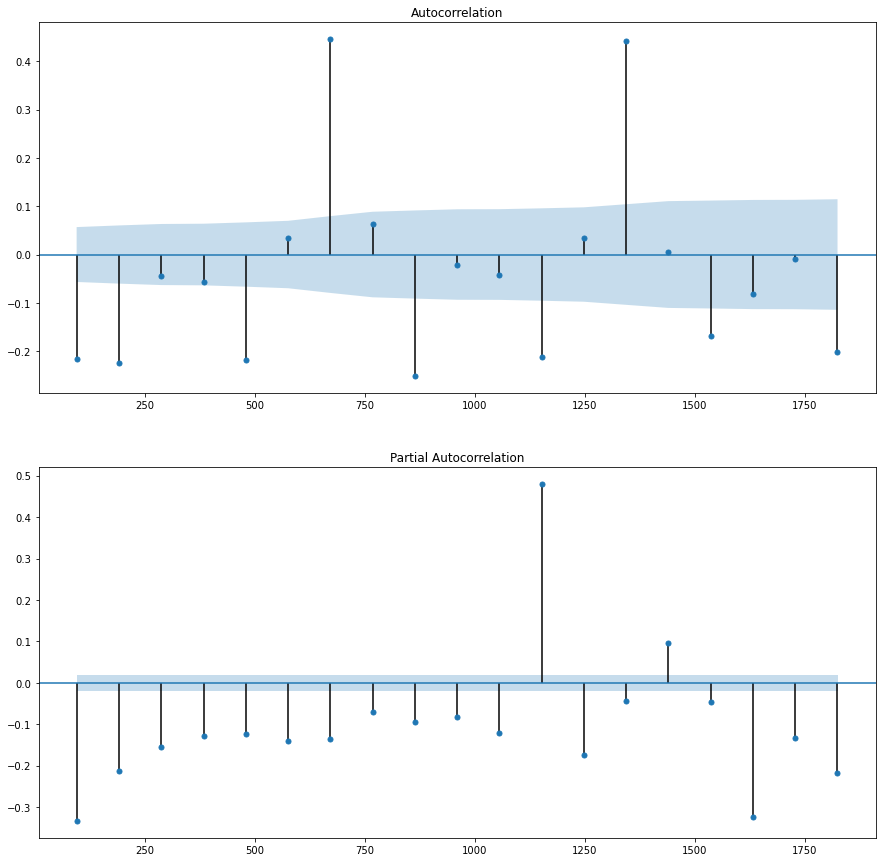

In [12]:
logins_15min_diff = logins_15min.diff(96).dropna()

lags=[]
for x in range(1,20):
    lags.append(x*96)

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,15))

# Plot the ACF on ax1
plot_acf(logins_15min_diff, zero=False, lags=lags, ax=ax1)

# Plot the PACF on ax2
plot_pacf(logins_15min_diff, zero=False, lags=lags, ax=ax2)

plt.show()

In [13]:
dates=logins_15min.index

In [14]:
y = logins_15min['num_logins']
y_train = y.iloc[:len(y)-2000]
y_test = y.iloc[len(y)-2000:]
# Fit the model
estimator = TBATS(seasonal_periods=[96, 7])
model = estimator.fit(y_train)

In [15]:
# Warning messages from the model, if any
for warning in model.warnings:
    print(warning)

print('Did the model fit?', model.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', model.aic)  # may be np.inf

# Lets check components used in the model
# print('\n\nMODEL SUMMARY\n\n')
params = model.params
components = model.params.components

print('Smoothing parameter', params.alpha)

print('Seasonal periods',
      components.seasonal_periods)  # TBATS may choose non-seasonal model even if you provide seasons
print('Harmonics amount for each season', components.seasonal_harmonics)
print('1st seasonal smoothing parameters', params.gamma_1())  # one value for each season
print('2nd seasonal smoothing parameters', params.gamma_2())  # one value for each season

print('Trend and damping', components.use_trend, components.use_damped_trend)
print('Trend', params.beta)
print('Damping', params.phi)

print('Use Box-Cox', components.use_box_cox)
print('Box-Cox lambda interval that was considered', components.box_cox_bounds)
print('Box-Cox lambda', params.box_cox_lambda)

print('ARMA residuals modelling', components.use_arma_errors)
print('ARMA(p, q)', components.p, components.q)
print('AR parameters', params.ar_coefs)
print('MA parameters', params.ma_coefs)

print('Seed state', params.x0)

# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(model.summary())

print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', model.y[:5])
print('Predictions (5 first values)', model.y_hat[:5])
print('Residuals (5 first values)', model.resid[:5])

Did the model fit? True
AIC 91731.9885948015
Smoothing parameter 0.46925129245753106
Seasonal periods [ 7. 96.]
Harmonics amount for each season [ 1 12]
1st seasonal smoothing parameters [-1.05663187e-07  7.69703172e-08]
2nd seasonal smoothing parameters [ 7.73998861e-08 -4.88179888e-08]
Trend and damping True True
Trend -0.030189856946131396
Damping 0.9344454728075311
Use Box-Cox False
Box-Cox lambda interval that was considered (0, 1)
Box-Cox lambda None
ARMA residuals modelling False
ARMA(p, q) 0 0
AR parameters []
MA parameters []
Seed state [-3.75267723e+00 -6.35299339e-02 -8.84273512e-02 -3.50576738e-03
  2.52544712e+00 -3.21482469e+00  1.75439444e+00 -1.21636354e+00
 -1.80412680e-01  2.26557206e-01 -1.10109659e+00  3.71942806e-01
  1.87629569e-01 -4.13070315e-01  3.42089819e-01 -1.72227032e-01
  2.45308762e+00  2.73409879e+00  1.77907120e-01  2.96277987e-01
  6.77652833e-01 -1.05034132e-01 -4.50953875e-01 -2.11958463e-02
  8.47296596e-02 -2.69504975e-01  2.35821997e-01  2.052048

In [16]:
# get confidence intervals for 95% level
# When you provide level it returns a tuple
y_forecasted, confidence_info = model.forecast(steps=2000, confidence_level=0.95)

# Print mean absolute errors
print('\n\nFORECAST\n\n')
print('Values', y_forecasted)
print('MAE (in sample)', np.mean(np.abs(model.resid)))
print('MAE (forecast)', np.mean(np.abs(y_forecasted - y_test)))

# Print forecast confidence intervals
print('Calculated for confidence level:', confidence_info['calculated_for_level'])

print('CALCULATIONS ARE VALID ONLY WHEN RESIDUALS HAVE NORMAL DISTRIBUTION')

print('Lower bound:', confidence_info['lower_bound'])
print('Predictions:', confidence_info['mean'])
print('Upper bound:', confidence_info['upper_bound'])



FORECAST


Values [11.56991595 11.1152651  10.77578876 ...  8.87298111  9.12664345
  9.28223567]
MAE (in sample) 2.980470065969579
MAE (forecast) 5.664911814803367
Calculated for confidence level: 0.95
CALCULATIONS ARE VALID ONLY WHEN RESIDUALS HAVE NORMAL DISTRIBUTION
Lower bound: [  3.58480652   2.388021     1.4414838  ... -10.31805257 -10.06690528
  -9.91382778]
Predictions: [11.56991595 11.1152651  10.77578876 ...  8.87298111  9.12664345
  9.28223567]
Upper bound: [19.55502539 19.84250921 20.11009371 ... 28.0640148  28.32019218
 28.47829913]


# logins with predictions

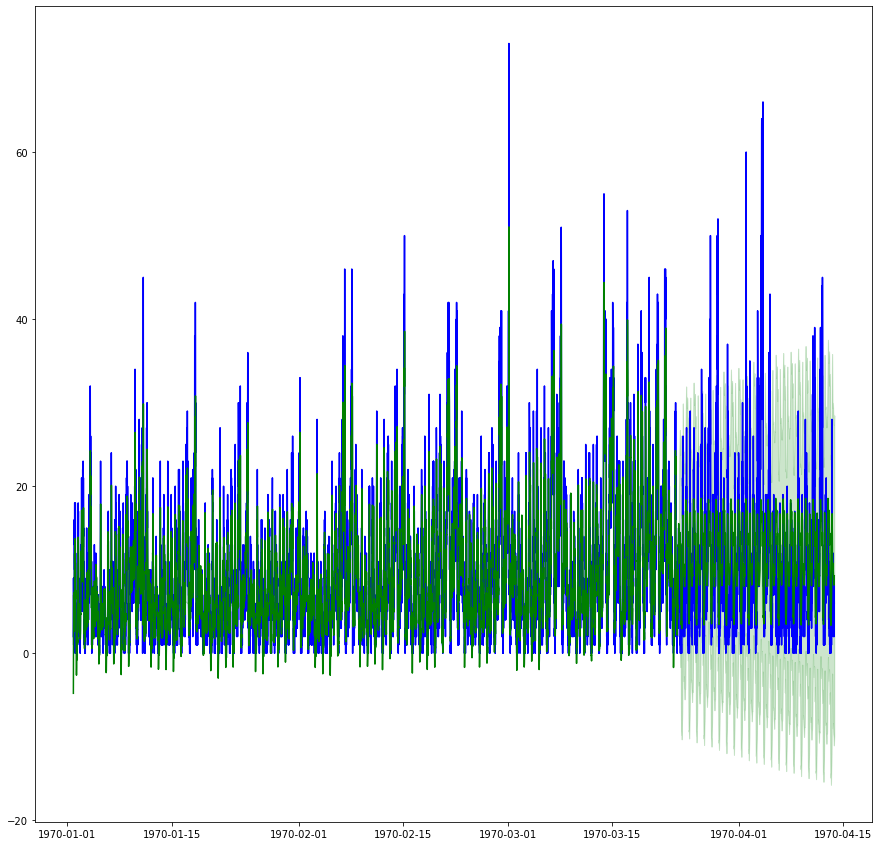

In [17]:
plt.figure(figsize=(15,15))
plt.plot(dates, logins_15min['num_logins'], color='blue')
plt.plot(dates[:-2000], model.y_hat, color='green')
plt.plot(dates[-2000:], y_forecasted, color='green')
plt.fill_between(dates[-2000:], confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.2, color='green')
plt.show()

### A single day on logins training

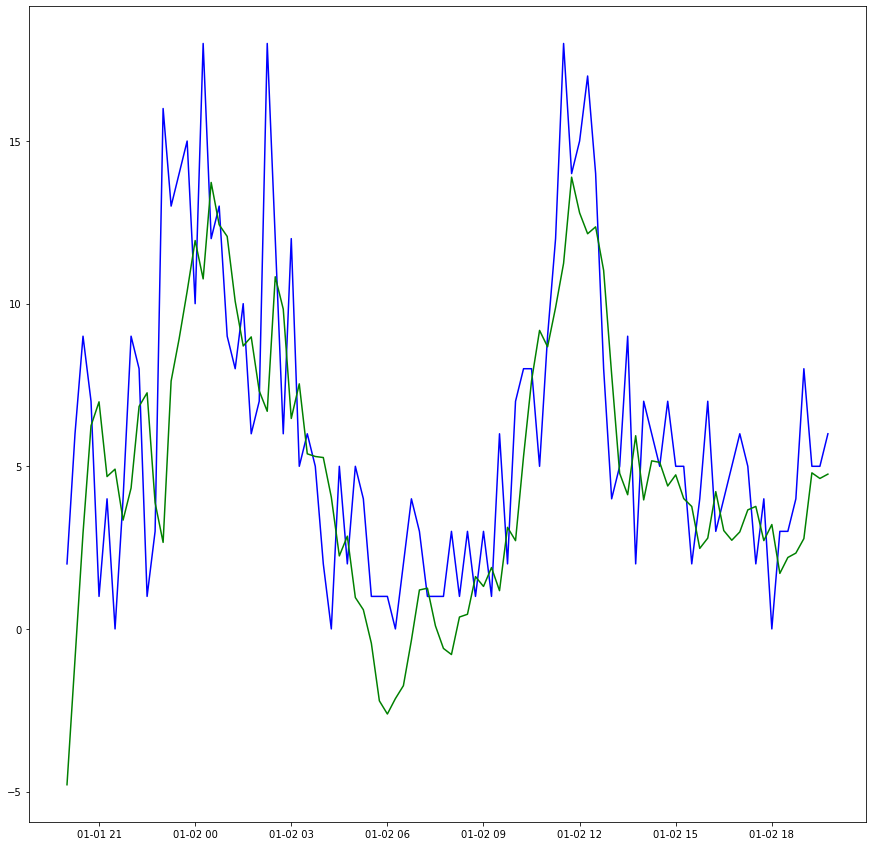

In [18]:
plt.figure(figsize=(15,15))
plt.plot(dates[:96],logins_15min['num_logins'][:96], color='blue')
plt.plot(dates[:96],model.y_hat[:96], color='green')
plt.show()

### A single day on logins forecasting

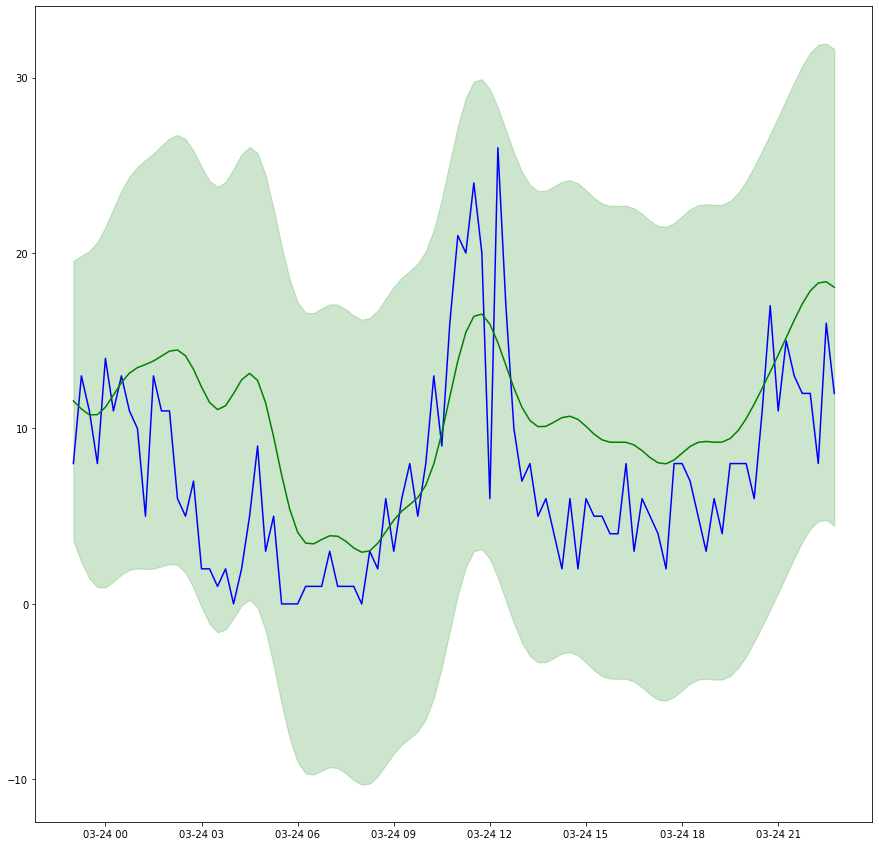

In [19]:
plt.figure(figsize=(15,15))
plt.plot(dates[-2000:-2000+96],logins_15min['num_logins'][-2000:-2000+96], color='blue')
plt.plot(dates[-2000:-2000+96],y_forecasted[:96], color='green')
plt.fill_between(dates[-2000:-2000+96], confidence_info['lower_bound'][:96], confidence_info['upper_bound'][:96], alpha=0.2, color='green')

plt.show()

### A single week on logins training

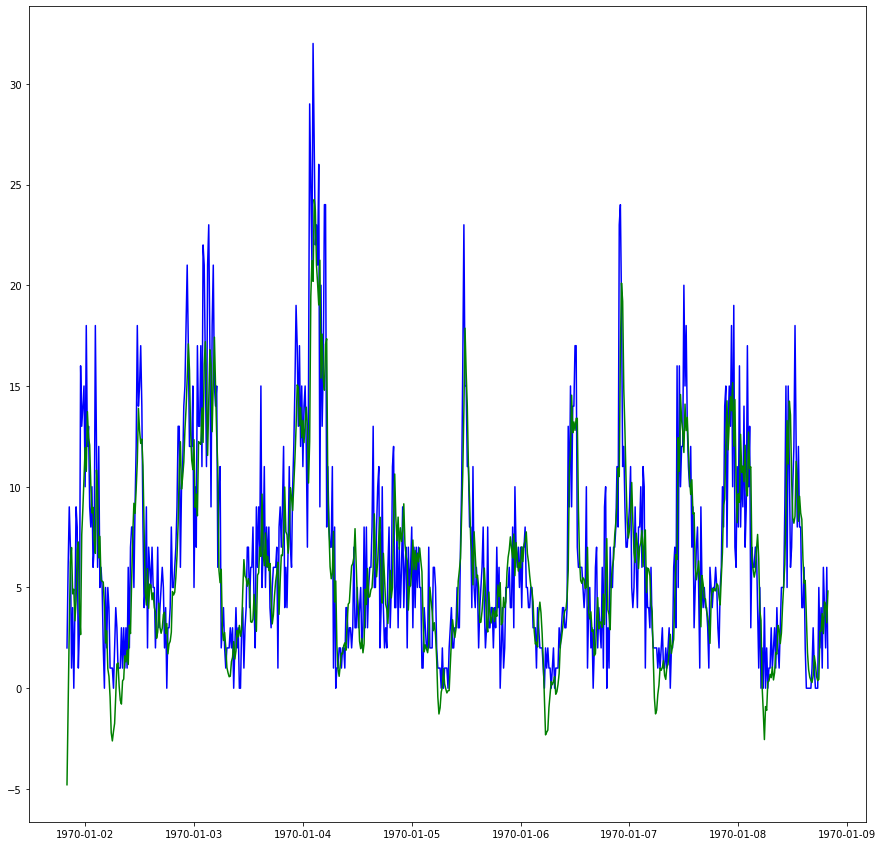

In [20]:
plt.figure(figsize=(15,15))
plt.plot(dates[:96*7],logins_15min['num_logins'][:96*7], color='blue')
plt.plot(dates[:96*7],model.y_hat[:96*7], color='green')
plt.show()

### A single week on logins forecasting

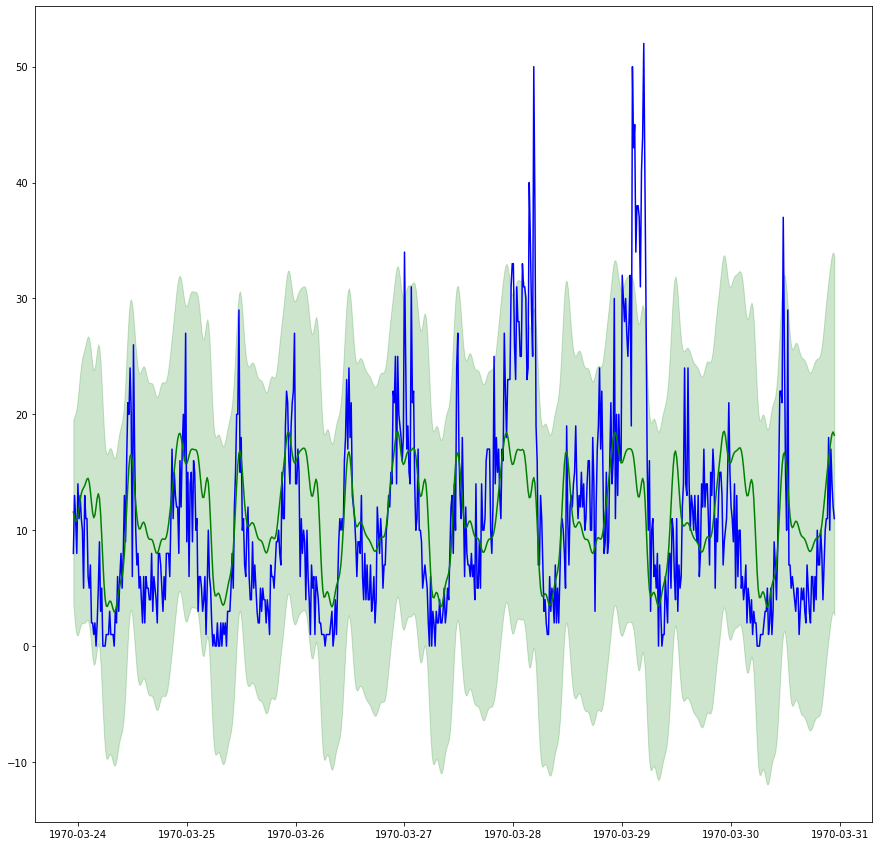

In [21]:
plt.figure(figsize=(15,15))
plt.plot(dates[-2000:-2000+96*7],logins_15min['num_logins'][-2000:-2000+96*7], color='blue')
plt.plot(dates[-2000:-2000+96*7],y_forecasted[:96*7], color='green')
plt.fill_between(dates[-2000:-2000+96*7], confidence_info['lower_bound'][:96*7], confidence_info['upper_bound'][:96*7], alpha=0.2, color='green')
plt.show()

# Let's try with all of logins

In [22]:
# Fit the model
estimator = TBATS(seasonal_periods=[96, 7])
model_all_logins = estimator.fit(y)

In [23]:
# Warning messages from the model, if any
for warning in model_all_logins.warnings:
    print(warning)

print('Did the model fit?', model_all_logins.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', model_all_logins.aic)  # may be np.inf

# Lets check components used in the model
# print('\n\nMODEL SUMMARY\n\n')
params = model_all_logins.params
components = model_all_logins.params.components

print('Smoothing parameter', params.alpha)

print('Seasonal periods',
      components.seasonal_periods)  # TBATS may choose non-seasonal model even if you provide seasons
print('Harmonics amount for each season', components.seasonal_harmonics)
print('1st seasonal smoothing parameters', params.gamma_1())  # one value for each season
print('2nd seasonal smoothing parameters', params.gamma_2())  # one value for each season

print('Trend and damping', components.use_trend, components.use_damped_trend)
print('Trend', params.beta)
print('Damping', params.phi)

print('Use Box-Cox', components.use_box_cox)
print('Box-Cox lambda interval that was considered', components.box_cox_bounds)
print('Box-Cox lambda', params.box_cox_lambda)

print('ARMA residuals modelling', components.use_arma_errors)
print('ARMA(p, q)', components.p, components.q)
print('AR parameters', params.ar_coefs)
print('MA parameters', params.ma_coefs)

print('Seed state', params.x0)

# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(model_all_logins.summary())

print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', model_all_logins.y[:5])
print('Predictions (5 first values)', model_all_logins.y_hat[:5])
print('Residuals (5 first values)', model_all_logins.resid[:5])

Did the model fit? True
AIC 118077.12218085342
Smoothing parameter 0.4845230220488048
Seasonal periods [ 7. 96.]
Harmonics amount for each season [ 1 12]
1st seasonal smoothing parameters [ 0.00037978 -0.00028812]
2nd seasonal smoothing parameters [-7.60173985e-07 -1.10231661e-04]
Trend and damping True True
Trend -0.03090978749522762
Damping 0.935610594925015
Use Box-Cox False
Box-Cox lambda interval that was considered (0, 1)
Box-Cox lambda None
ARMA residuals modelling False
ARMA(p, q) 0 0
AR parameters []
MA parameters []
Seed state [-3.6887152  -0.0751226  -0.07243115  0.0261926   2.62748821 -3.19348284
  1.82695164 -1.2426195  -0.11079568  0.26291133 -1.12213011  0.3600177
  0.16503456 -0.39034396  0.30670617 -0.17585636  2.60114067  2.81592837
  0.11262701  0.19406686  0.60669713 -0.08971627 -0.3891113  -0.03590362
  0.05771283 -0.24403124  0.18010636  0.14899389]


SUMMARY FUNCTION


Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [ 7. 96.]
Seasonal 

In [24]:
# get confidence intervals for 95% level
# When you provide level it returns a tuple
y_forecasted, confidence_info = model_all_logins.forecast(steps=2000, confidence_level=0.95)

# Print mean absolute errors
print('\n\nFORECAST\n\n')
print('Values', y_forecasted)
print('MAE (in sample)', np.mean(np.abs(model_all_logins.resid)))
# print('MAE (forecast)', np.mean(np.abs(y_forecasted - y_test)))

# Print forecast confidence intervals
print('Calculated for confidence level:', confidence_info['calculated_for_level'])

print('CALCULATIONS ARE VALID ONLY WHEN RESIDUALS HAVE NORMAL DISTRIBUTION')

print('Lower bound:', confidence_info['lower_bound'])
print('Predictions:', confidence_info['mean'])
print('Upper bound:', confidence_info['upper_bound'])



FORECAST


Values [6.32489203 6.61792836 6.96244806 ... 9.40204466 9.28579755 9.02014804]
MAE (in sample) 3.041370852955159
Calculated for confidence level: 0.95
CALCULATIONS ARE VALID ONLY WHEN RESIDUALS HAVE NORMAL DISTRIBUTION
Lower bound: [ -1.89554059  -2.40502039  -2.713802   ...  -9.65153186  -9.77002335
 -10.03785866]
Predictions: [6.32489203 6.61792836 6.96244806 ... 9.40204466 9.28579755 9.02014804]
Upper bound: [14.54532464 15.64087711 16.63869813 ... 28.45562117 28.34161844
 28.07815474]


In [25]:
dates_forecast = pd.DataFrame(index=pd.date_range(start='1970-01-01 20:00:00', periods=9788+2000, freq='15T')).index

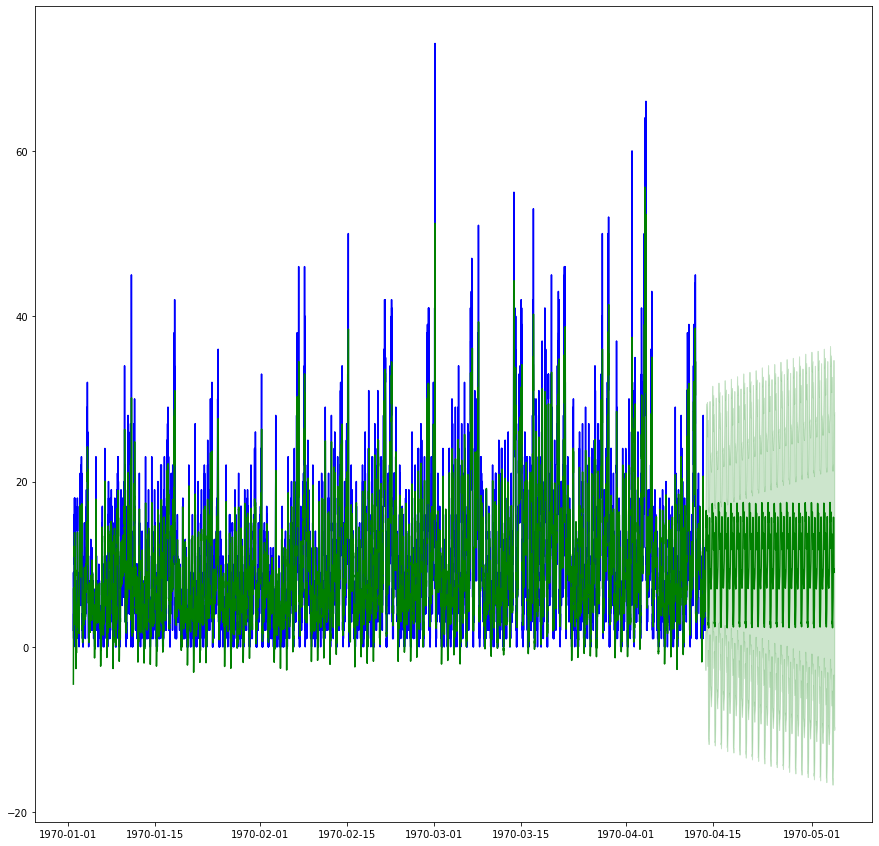

In [26]:
plt.figure(figsize=(15,15))
plt.plot(dates, logins_15min['num_logins'], color='blue')
plt.plot(dates, model_all_logins.y_hat, color='green')
plt.plot(dates_forecast[-2000:],y_forecasted, color='green')
plt.fill_between(dates_forecast[-2000:], confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.2, color='green')
plt.show()

In [27]:
prediction = pd.DataFrame(index=dates_forecast[-2000:])
prediction['num_logins'] = y_forecasted
prediction['lower_bound'] = confidence_info['lower_bound']
prediction['upper_bound'] = confidence_info['upper_bound']

## The seasonal decomposition showed that there wasn't a steady trend.  The end of the dataset wasn't trending up or down, so the forecast predicts something similar with the trends being about the same for each day of the week.  There were a few notable local mins/maxes throughout the day.

# First Monday forecast

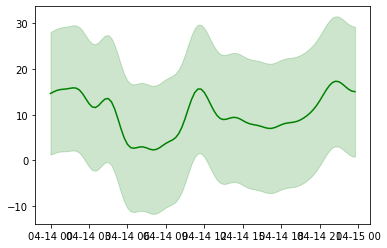

In [28]:
plt.plot(prediction['num_logins']['1970-04-14'], color='green')
plt.fill_between(prediction['1970-04-14'].index,prediction['lower_bound']['1970-04-14'], prediction['upper_bound']['1970-04-14'], alpha=0.2, color='green')
plt.show()

# First Tuesday forecast

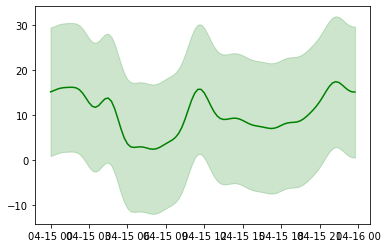

In [29]:
plt.plot(prediction['num_logins']['1970-04-15'], color='green')
plt.fill_between(prediction['1970-04-15'].index,prediction['lower_bound']['1970-04-15'], prediction['upper_bound']['1970-04-15'], alpha=0.2, color='green')
plt.show()

# First Wednesday forecast

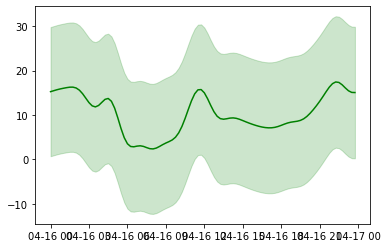

In [30]:
plt.plot(prediction['num_logins']['1970-04-16'], color='green')
plt.fill_between(prediction['1970-04-16'].index,prediction['lower_bound']['1970-04-16'], prediction['upper_bound']['1970-04-16'], alpha=0.2, color='green')
plt.show()

# First Thursday forecast

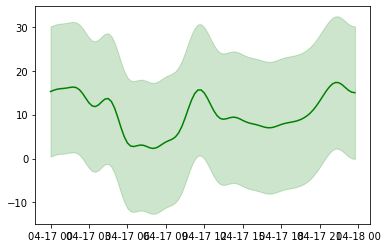

In [31]:
plt.plot(prediction['num_logins']['1970-04-17'], color='green')
plt.fill_between(prediction['1970-04-17'].index,prediction['lower_bound']['1970-04-17'], prediction['upper_bound']['1970-04-17'], alpha=0.2, color='green')
plt.show()

# First Friday forecast

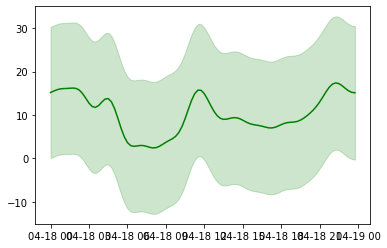

In [32]:
plt.plot(prediction['num_logins']['1970-04-18'], color='green')
plt.fill_between(prediction['1970-04-18'].index,prediction['lower_bound']['1970-04-18'], prediction['upper_bound']['1970-04-18'], alpha=0.2, color='green')
plt.show()

# First Saturday forecast

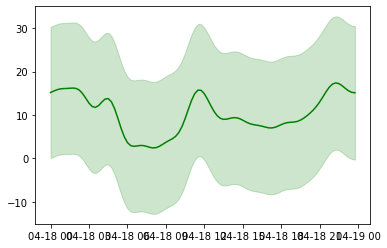

In [33]:
plt.plot(prediction['num_logins']['1970-04-18'], color='green')
plt.fill_between(prediction['1970-04-18'].index,prediction['lower_bound']['1970-04-18'], prediction['upper_bound']['1970-04-18'], alpha=0.2, color='green')
plt.show()

# First Sunday forecast

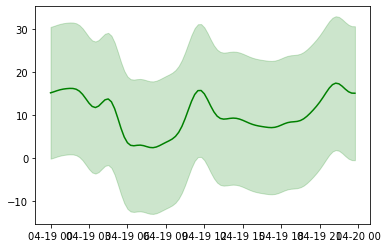

In [34]:
plt.plot(prediction['num_logins']['1970-04-19'], color='green')
plt.fill_between(prediction['1970-04-19'].index,prediction['lower_bound']['1970-04-19'], prediction['upper_bound']['1970-04-19'], alpha=0.2, color='green')
plt.show()

In [35]:
prediction[prediction['num_logins']==prediction['1970-04-15 00:00:00':'1970-04-15 04:00:00']['num_logins'].max()]

,num_logins,lower_bound,upper_bound
1970-04-15 01:30:00,16.183032,1.8919,30.474164


In [36]:
prediction[prediction['num_logins']==prediction['1970-04-15 00:00:00':'1970-04-15 04:00:00']['num_logins'].min()]

,num_logins,lower_bound,upper_bound
1970-04-15 03:30:00,11.732385,-2.582626,26.047395


In [37]:
prediction[prediction['num_logins']==prediction['1970-04-15 04:00:00':'1970-04-15 12:00:00']['num_logins'].min()]

,num_logins,lower_bound,upper_bound
1970-04-15 08:00:00,2.426023,-11.942658,16.794705


In [38]:
prediction[prediction['num_logins']==prediction['1970-04-15 04:00:00':'1970-04-15 12:00:00']['num_logins'].max()]

,num_logins,lower_bound,upper_bound
1970-04-15 11:30:00,15.738456,1.328205,30.148708


In [39]:
prediction[prediction['num_logins']==prediction['1970-04-15 12:00:00':'1970-04-15 23:59:59']['num_logins'].min()]

,num_logins,lower_bound,upper_bound
1970-04-15 17:15:00,7.033005,-7.445474,21.511483


In [40]:
prediction[prediction['num_logins']==prediction['1970-04-15 12:00:00':'1970-04-15 23:59:59']['num_logins'].max()]

,num_logins,lower_bound,upper_bound
1970-04-15 22:15:00,17.432773,2.897702,31.967844


# Resampling the dataset at 1 day freq

In [41]:
logins_day = logins.resample('1d').sum()

# The day with the most logins

In [42]:
logins_day[logins_day['num_logins'] == logins_day['num_logins'].max()]

,num_logins
login_time,
1970-04-04,1889


# The last day of the 7-day period with the most logins

In [43]:
logins_day['weekly'] = logins_day['num_logins'].rolling(7).sum()
logins_day[logins_day['weekly'] == logins_day['weekly'].max()]

,num_logins,weekly
login_time,,
1970-03-20,1215,9269.0


# Part 2

## We're trying to test the success of an experiment in which the Uber-esque company (Ultimate) reimburses drivers for tolls between cities Gotham and Metropolis in order to get more customers.  We should see an increase in drive distances due to greater willingness to cross the bridge.  We should also see an increase in the total number of rides due to more routes being offered.  (Ideally, we'd have location/zip code data of start/stop points of rides, but that doesn't seem offered.)

### a. We'd implement this experiment by getting at least a few weeks of data from a promo period of time in which tolls were paid by Ultimate.  Using start/end point location data, we could see the raw # of rides between the two cities.  We could also compare the sum of the distance of rides and # of rides on an hourly basis for each day of the week.  We'd expect to see more of both, and we could express the increase in raw amounts and percents.

### b. We could use the ADFuller Test to make sure that our data is properly differenced and stationary.

### c. Using profit data for each ride we could judge if the rides turned a profit given that Ultimate is having to bear the cost of the toll.  The increase in total miles driven and number of rides could possibly paint a picture of overall increase in the use of their service.  This could possibly be useful in determining whether even a loss in proft might be acceptable if it provides a large enough boon in customer satisfaction and favorability over a similar company.

# Now the users data

In [44]:
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)
users = pd.DataFrame(data)

In [45]:
users.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000,NaN,NaN,NaN,2.2782,3.79268,0,0,1,3,125
signup_date,50000,31,2014-01-18,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,41878,NaN,NaN,NaN,4.60156,0.617338,1,4.3,4.9,5,5
avg_surge,50000,NaN,NaN,NaN,1.07476,0.222336,1,1,1,1.05,8
last_trip_date,50000,182,2014-06-29,2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,49604,2,iPhone,34582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000,NaN,NaN,NaN,8.84954,19.9588,0,0,0,8.6,100
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000,NaN,NaN,NaN,60.9261,37.0815,0,33.3,66.7,100,100


In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [47]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [48]:
users.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [49]:
(100*users[users.columns[users.isnull().any()]].isnull().sum()/len(users.index)).sort_values()

avg_rating_by_driver     0.402
phone                    0.792
avg_rating_of_driver    16.244
dtype: float64

### There's really no way for us to infer the phone type, so we'll drop thos NaNs.

In [50]:
users.dropna(subset=['phone'], inplace=True)

In [51]:
users['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

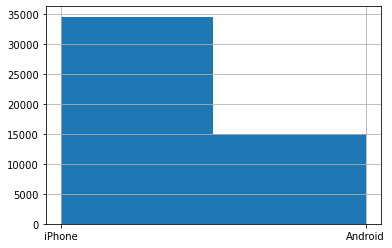

In [52]:
users['phone'].hist(bins=2)

### Since it's possible to not rate users, we'll fill those NaNs with 0.

In [53]:
users['avg_rating_of_driver'].fillna(value=0, inplace=True)
users['avg_rating_by_driver'].fillna(value=0, inplace=True)     

In [54]:
users['avg_rating_of_driver'].value_counts()

5.0    20625
0.0     8026
4.0     4167
4.5     2473
4.8     2408
4.7     1934
4.9     1757
4.3     1473
4.6     1133
3.0      993
4.4      826
4.2      598
3.5      484
3.8      428
4.1      396
3.7      363
3.9      254
1.0      254
2.0      208
3.3      200
3.6      170
3.4      108
2.5       93
3.2       53
2.7       47
3.1       38
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

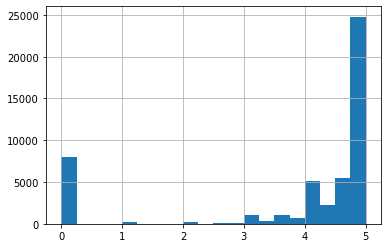

In [55]:
users['avg_rating_of_driver'].hist(bins=20)

In [56]:
users['avg_rating_by_driver'].value_counts()

5.0    28271
4.8     4493
4.7     3309
4.9     3068
4.5     2403
4.6     2072
4.0     1896
4.3     1014
4.4      854
3.0      598
4.2      340
0.0      198
3.5      197
3.7      195
1.0      180
2.0      126
4.1      124
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
2.7        2
3.2        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

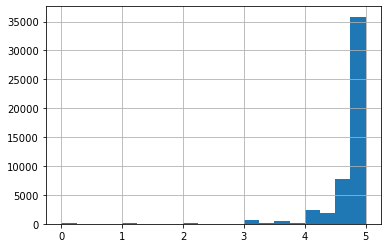

In [57]:
users['avg_rating_by_driver'].hist(bins=20)

In [58]:
users['city'].value_counts()

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64

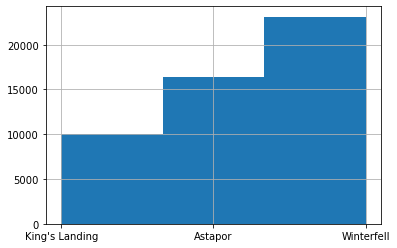

In [59]:
users['city'].hist(bins=3)

In [60]:
users['trips_in_first_30_days'].value_counts()

0      15312
1      13952
2       7334
3       3759
4       2547
5       1605
6       1128
7        814
8        584
9        470
10       346
11       297
12       218
13       168
15       154
14       144
17       113
16       106
18        80
19        68
20        51
23        44
21        38
22        34
24        33
27        27
28        21
25        19
26        19
30        15
34        11
29         9
33         9
37         9
32         8
31         6
44         5
40         5
38         4
43         4
47         3
42         3
36         3
39         3
53         2
55         2
56         2
54         2
48         2
49         2
35         2
125        1
73         1
58         1
71         1
41         1
50         1
51         1
63         1
Name: trips_in_first_30_days, dtype: int64

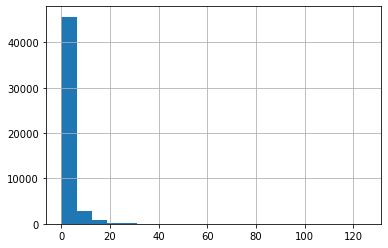

In [61]:
users['trips_in_first_30_days'].hist(bins=20)

In [62]:
users['avg_surge'].value_counts()

1.00    34156
1.25     1093
1.13      949
1.02      800
1.08      794
1.06      767
1.04      762
1.05      698
1.07      614
1.03      613
1.10      506
1.50      502
1.01      478
1.17      471
1.11      445
1.09      409
1.15      367
1.14      339
1.19      324
1.75      294
1.38      294
2.00      260
1.16      253
1.20      242
1.21      214
1.18      214
1.33      199
1.12      193
1.22      163
1.31      135
2.25      122
1.63      114
1.29      112
1.42      108
1.23      105
1.30       97
2.50       96
3.00       77
1.27       71
1.28       69
1.44       59
1.88       57
1.40       57
1.32       56
1.67       56
1.35       54
1.58       54
2.75       48
1.24       45
1.34       36
1.36       36
1.56       32
1.39       32
1.26       30
1.45       28
1.54       24
3.25       23
1.46       22
1.83       21
1.41       21
1.55       19
2.13       18
1.60       17
1.69       17
1.92       14
1.43       14
4.00       12
2.38       11
1.70       11
1.48       10
3.50        9
1.65  

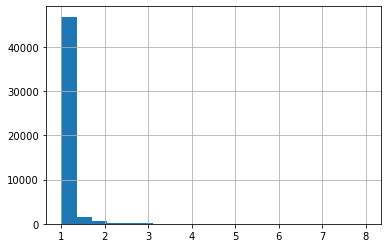

In [63]:
users['avg_surge'].hist(bins=20)

In [64]:
users['surge_pct'].value_counts()

0.0      34111
100.0     1410
50.0      1361
33.3      1147
25.0       897
20.0       787
16.7       703
14.3       531
12.5       436
11.1       391
10.0       333
9.1        293
8.3        255
7.7        218
22.2       209
7.1        204
40.0       201
28.6       189
66.7       168
6.3        158
18.2       157
6.7        146
5.9        139
15.4       134
11.8       117
5.6        114
5.3        103
13.3        99
4.8         79
5.0         78
21.4        74
27.3        73
37.5        73
9.5         73
30.0        72
4.5         72
10.5        71
23.1        69
18.8        66
3.8         64
4.3         64
17.6        63
42.9        61
4.2         60
21.1        51
13.6        50
13.0        49
4.0         48
3.7         44
3.4         44
2.4         43
60.0        43
3.6         43
7.4         43
23.5        42
8.7         42
8.0         41
3.0         41
15.8        41
2.9         38
3.3         38
10.3        37
2.6         36
3.1         36
19.0        35
75.0        34
30.8      

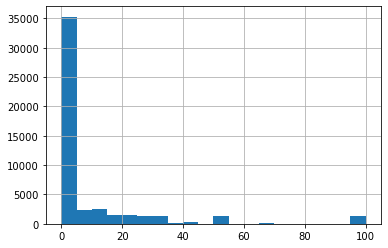

In [65]:
users['surge_pct'].hist(bins=20)

In [66]:
users['ultimate_black_user'].value_counts()

False    30992
True     18612
Name: ultimate_black_user, dtype: int64

In [67]:
users['weekday_pct'].value_counts()

100.0    16499
0.0       9142
50.0      4020
66.7      2070
33.3      1608
75.0      1095
60.0       765
25.0       717
80.0       664
40.0       588
83.3       397
71.4       394
57.1       393
20.0       343
42.9       284
85.7       279
62.5       255
87.5       239
55.6       218
44.4       210
37.5       195
16.7       195
77.8       192
28.6       174
70.0       171
63.6       165
88.9       160
58.3       157
54.5       149
72.7       143
45.5       117
90.0       108
53.8       108
61.5       107
81.8       107
69.2       105
36.4        99
14.3        97
64.3        94
46.2        87
76.9        85
41.7        81
90.9        79
30.0        77
73.3        76
68.8        73
22.2        72
91.7        67
84.6        65
53.3        65
70.6        65
38.5        64
78.6        62
76.5        60
56.3        60
61.1        59
12.5        59
64.7        58
63.2        57
27.3        56
58.8        55
46.7        55
86.7        52
68.4        48
92.9        47
92.3        46
52.9      

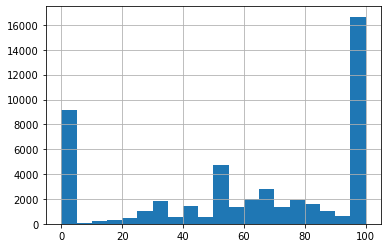

In [68]:
users['weekday_pct'].hist(bins=20)

In [69]:
users['avg_dist'].value_counts()

0.00      149
2.29      115
2.30      114
2.36      114
2.73      114
2.70      114
2.65      113
2.50      113
2.40      110
2.83      109
2.54      109
2.42      109
2.32      108
2.05      108
2.62      107
2.15      107
2.74      107
2.47      106
2.01      106
3.00      106
2.89      105
2.60      105
2.92      104
2.06      104
2.59      104
3.05      104
2.57      103
1.91      103
2.34      103
2.38      103
2.96      103
2.22      103
2.77      103
2.46      103
2.37      103
2.79      102
2.02      102
2.27      101
3.07      100
2.41      100
2.75      100
2.03       99
2.69       99
2.58       99
2.63       99
2.43       99
2.17       99
1.95       98
2.68       98
3.11       98
2.71       98
2.72       98
2.94       97
1.99       97
3.23       97
2.99       97
3.09       96
1.88       96
2.78       96
2.85       96
2.31       95
2.19       95
3.12       95
2.86       95
2.51       95
2.52       94
2.39       94
2.20       94
2.10       94
2.48       94
2.26       94
2.66  

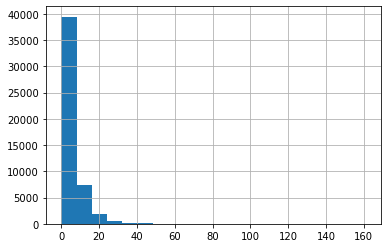

In [70]:
users['avg_dist'].hist(bins=20)

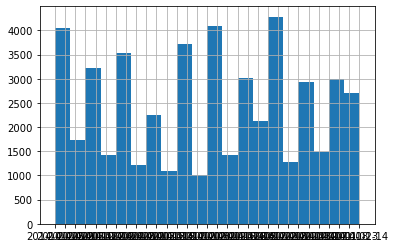

In [71]:
users['signup_date'].hist(bins=20)

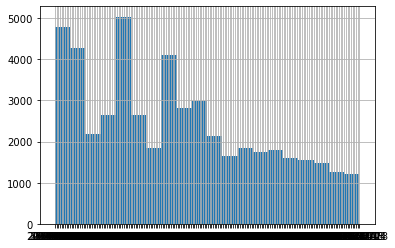

In [72]:
users['last_trip_date'].hist(bins=20)

In [73]:
users['last_trip_date'].max()

'2014-07-01'

In [74]:
users['last_trip_date']=pd.to_datetime(users['last_trip_date'])
users['signup_date']=pd.to_datetime(users['signup_date'])

## 36.65% of users who signed up in Jan are retained as of July 01.

In [75]:
(users['last_trip_date']>'2014-06-01').sum()/len(users)

0.3665027013950488

## Modeling

In [76]:
users['retained'] = 0
for x in range(len(users)):
    if users['last_trip_date'].iloc[x]>pd.to_datetime('2014-06-01'):
        users['retained'].iloc[x] = 1

In [78]:
users['ultimate_black_user']=users['ultimate_black_user'].astype('int32')

In [80]:
dummies = pd.get_dummies(data=users, columns=['city','phone'], prefix=['city','OS'], dtype=int)

In [81]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  datetime64[ns]
 2   avg_rating_of_driver    49604 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int32         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49604 non-null  float64       
 10  retained                49604 non-null  int64         
 11  city_Astapor            49604 non-null  int32         
 12  city_King's Landing     49604 non-null  int32 

In [82]:
X = dummies.drop(['last_trip_date','retained','signup_date'], axis=1)
y = dummies['retained'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# build scaler based on training data and apply it to test data to then also scale the test data
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [83]:
categorical_features = ['OS_Android','OS_iPhone','city_Winterfell',"city_King's Landing",'city_Astapor','ultimate_black_user']

## Testing different LightGBM models using Bayesian Boosting
gbdt: traditional Gradient Boosting Decision Tree

rf: Random Forest

dart: Dropouts meet Multiple Additive Regression Trees

goss: Gradient-based One-Side Sampling

In [93]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO4325 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001,.9),
                                        "lambda_l1" : (.001,.9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
                                         })

# logger = JSONLogger(path="./log0.json")
# lgbBO0.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO4325.maximize(init_points=20, n_iter=30)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8581   |  0.5807   |  0.4553   |  0.1477   |  689.1    |  789.4    |  319.0    |
|  2        |  0.8585   |  0.2304   |  0.7185   |  0.2914   |  33.06    |  694.6    |  297.5    |
|  3        |  0.8546   |  0.247    |  0.1693   |  0.7489   |  893.1    |  893.2    |  809.4    |
|  4        |  0.8569   |  0.1567   |  0.8588   |  0.517    |  470.7    |  689.8    |  85.01    |
|  5        |  0.8568   |  0.6508   |  0.3488   |  0.1105   |  932.9    |  857.8    |  769.6    |
|  6        |  0.8547   |  0.06391  |  0.2342   |  0.7715   |  40.61    |  740.3    |  683.5    |
|  7        |  0.8547   |  0.3792   |  0.5187   |  0.6649   |  442.9    |  756.8    |  823.4    |
|  8        |  0.8573   |  0.603    |  0.05666  |  0.3625   |  607.5    |  527.6    |  586.5    |
|  9        |  0.847

In [94]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate, bagging_fraction):
    params = {
        "objective" : "binary",
        'boosting': 'rf',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100,
        'bagging_freq': 1,
        'bagging_fraction': bagging_fraction
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO141 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9),
#                                         'feature_fraction': (.1,.9),
                                        'bagging_fraction': (.001,.9)
                                         })

# logger = JSONLogger(path="./log1.json")
# lgbBO1.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO141.maximize(init_points=20, n_iter=30)

|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7956   |  0.518    |  0.08982  |  0.3273   |  0.4754   |  754.2    |  775.1    |  770.2    |
|  2        |  0.7285   |  0.1336   |  0.01005  |  0.681    |  0.6457   |  424.7    |  644.0    |  663.5    |
|  3        |  0.7842   |  0.4756   |  0.3673   |  0.4608   |  0.3988   |  534.6    |  890.8    |  688.4    |
|  4        |  0.7265   |  0.143    |  0.324    |  0.00442  |  0.7348   |  7.046    |  710.7    |  570.7    |
|  5        |  0.8109   |  0.1732   |  0.3283   |  0.6889   |  0.4049   |  753.0    |  230.5    |  184.2    |
|  6        |  0.8261   |  0.8803   |  0.8514   |  0.6048   |  0.7031   |  659.0    |  285.3    |  248.5    |
|  7        |  0.8396   |  0.2436   |  0.519    |  0.6877   |  0.1702   |  205.0    |  51.02    |  910.1    |
|  8      

|  45       |  0.8333   |  0.1645   |  0.7491   |  0.8212   |  0.6201   |  122.9    |  65.57    |  905.9    |
|  46       |  0.8441   |  0.1406   |  0.8268   |  0.08444  |  0.7958   |  135.9    |  20.88    |  761.9    |
|  47       |  0.8396   |  0.3524   |  0.5139   |  0.5208   |  0.09668  |  549.5    |  67.89    |  206.0    |
|  48       |  0.8468   |  0.5006   |  0.3894   |  0.7298   |  0.4677   |  50.34    |  26.15    |  786.5    |
|  49       |  0.8445   |  0.8838   |  0.2324   |  0.1338   |  0.816    |  835.5    |  25.08    |  267.7    |
|  50       |  0.8425   |  0.5621   |  0.1478   |  0.1728   |  0.8351   |  906.3    |  74.73    |  305.5    |


In [95]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'dart',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO7427 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log2.json")
# lgbBO2.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO7427.maximize(init_points=20, n_iter=30)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8565   |  0.1327   |  0.4833   |  0.5859   |  504.8    |  592.2    |  462.3    |
|  2        |  0.8573   |  0.4388   |  0.2644   |  0.7375   |  41.5     |  919.6    |  263.6    |
|  3        |  0.8544   |  0.3772   |  0.6028   |  0.1162   |  225.0    |  314.0    |  57.82    |
|  4        |  0.8545   |  0.5253   |  0.6226   |  0.09331  |  186.8    |  227.6    |  145.9    |
|  5        |  0.8568   |  0.4068   |  0.06926  |  0.3644   |  44.5     |  808.6    |  609.3    |
|  6        |  0.8567   |  0.8502   |  0.658    |  0.5868   |  728.3    |  914.6    |  181.1    |
|  7        |  0.8566   |  0.8046   |  0.342    |  0.6878   |  206.8    |  763.3    |  112.6    |
|  8        |  0.8562   |  0.8201   |  0.5394   |  0.2928   |  513.7    |  340.3    |  501.7    |
|  9        |  0.841

In [96]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'goss',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO987 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log3.json")
# lgbBO3.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO987.maximize(init_points=20, n_iter=30)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8397   |  0.03088  |  0.5736   |  0.8901   |  66.94    |  331.9    |  660.4    |
|  2        |  0.851    |  0.1528   |  0.4077   |  0.357    |  374.3    |  997.2    |  665.1    |
|  3        |  0.85     |  0.5281   |  0.7683   |  0.07378  |  864.8    |  731.4    |  706.0    |
|  4        |  0.8497   |  0.5366   |  0.65     |  0.02054  |  34.74    |  228.9    |  801.2    |
|  5        |  0.8535   |  0.654    |  0.457    |  0.2036   |  170.1    |  215.5    |  475.2    |
|  6        |  0.8464   |  0.5732   |  0.5473   |  0.7076   |  419.7    |  525.0    |  914.2    |
|  7        |  0.8458   |  0.5633   |  0.2642   |  0.2914   |  485.6    |  49.07    |  538.1    |
|  8        |  0.8445   |  0.2489   |  0.6405   |  0.8246   |  534.8    |  972.3    |  881.7    |
|  9        |  0.847

## GBDT performed the best out of these models.

In [97]:
lgbBO4325.max

{'target': 0.859006203347265,
 'params': {'lambda_l1': 0.8044162061107845,
  'lambda_l2': 0.30322125560150015,
  'learning_rate': 0.199459453303991,
  'max_depth': 977.7819972563382,
  'min_data_in_leaf': 644.3889415188694,
  'num_leaves': 795.4491938252467}}

In [101]:
params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        'feature_fraction': 1,
        'lambda_l1': .8044162061107845,
        'lambda_l2': 0.30322125560150015,
        'learning_rate': 0.199459453303991,
        'max_depth': 978,
        'min_data_in_leaf': 644,
        'num_leaves': 795,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 1000,
        'early_stopping_rounds': 100
}
    
lgtrain = lgbm.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgtest = lgbm.Dataset(X_test, y_test, categorical_feature=categorical_features)
lgclf = lgbm.train(
        params, 
        lgtrain,
        valid_sets=[lgtrain, lgtest],
        valid_names=["train", "test"],
        verbose_eval=100
)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.887591	test's auc: 0.863111
Early stopping, best iteration is:
[82]	train's auc: 0.884448	test's auc: 0.863386


In [138]:
1/(1+np.exp(-1*-0.9))

0.289050497374996

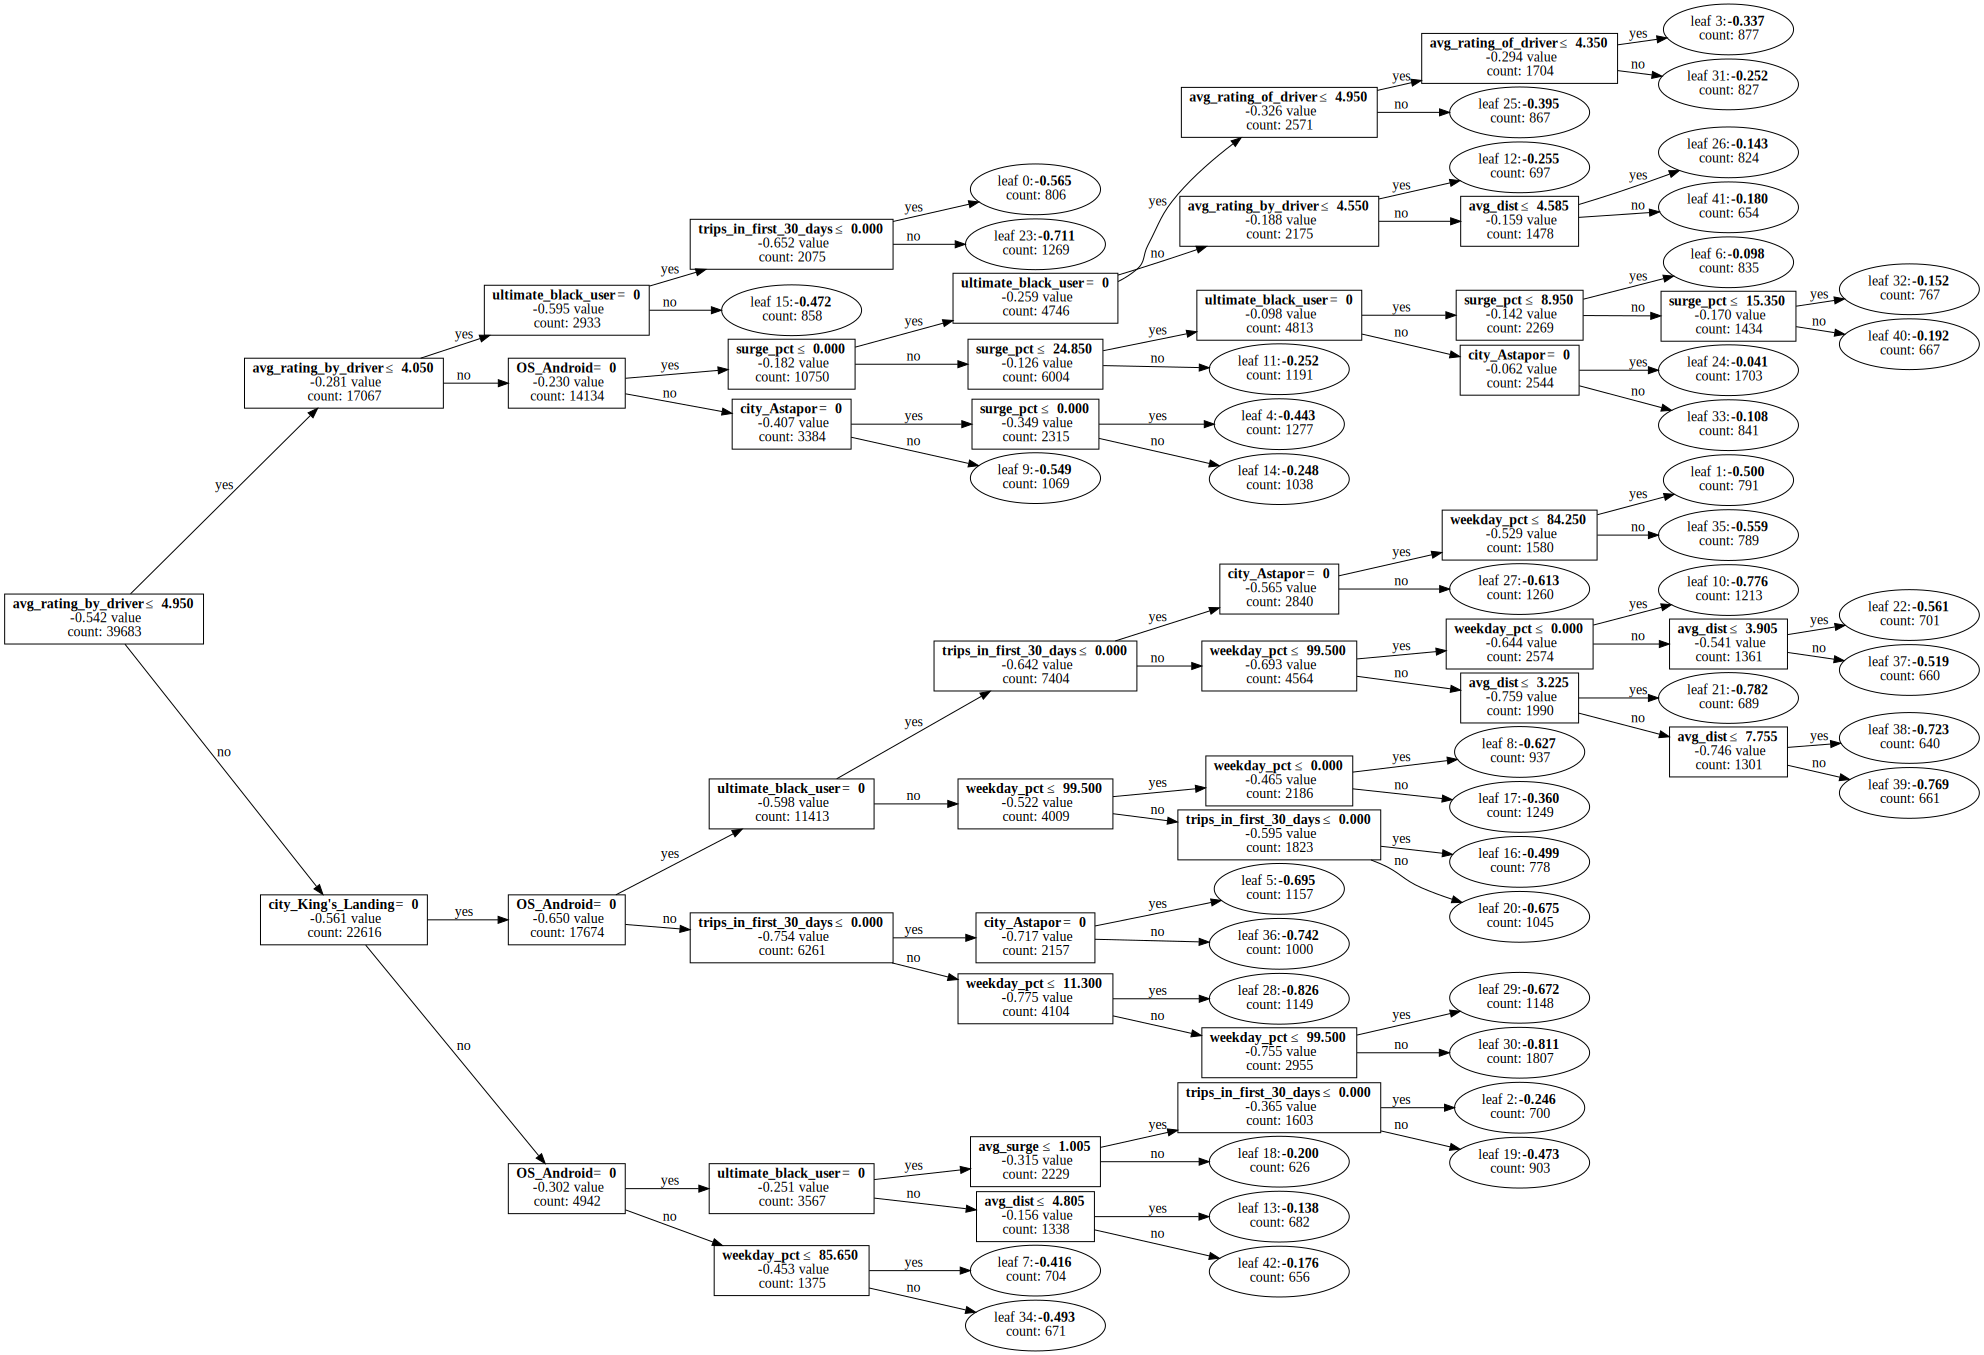

In [146]:
lgbm.create_tree_digraph(lgclf, show_info=('internal_value','internal_count', 'leaf_count'))

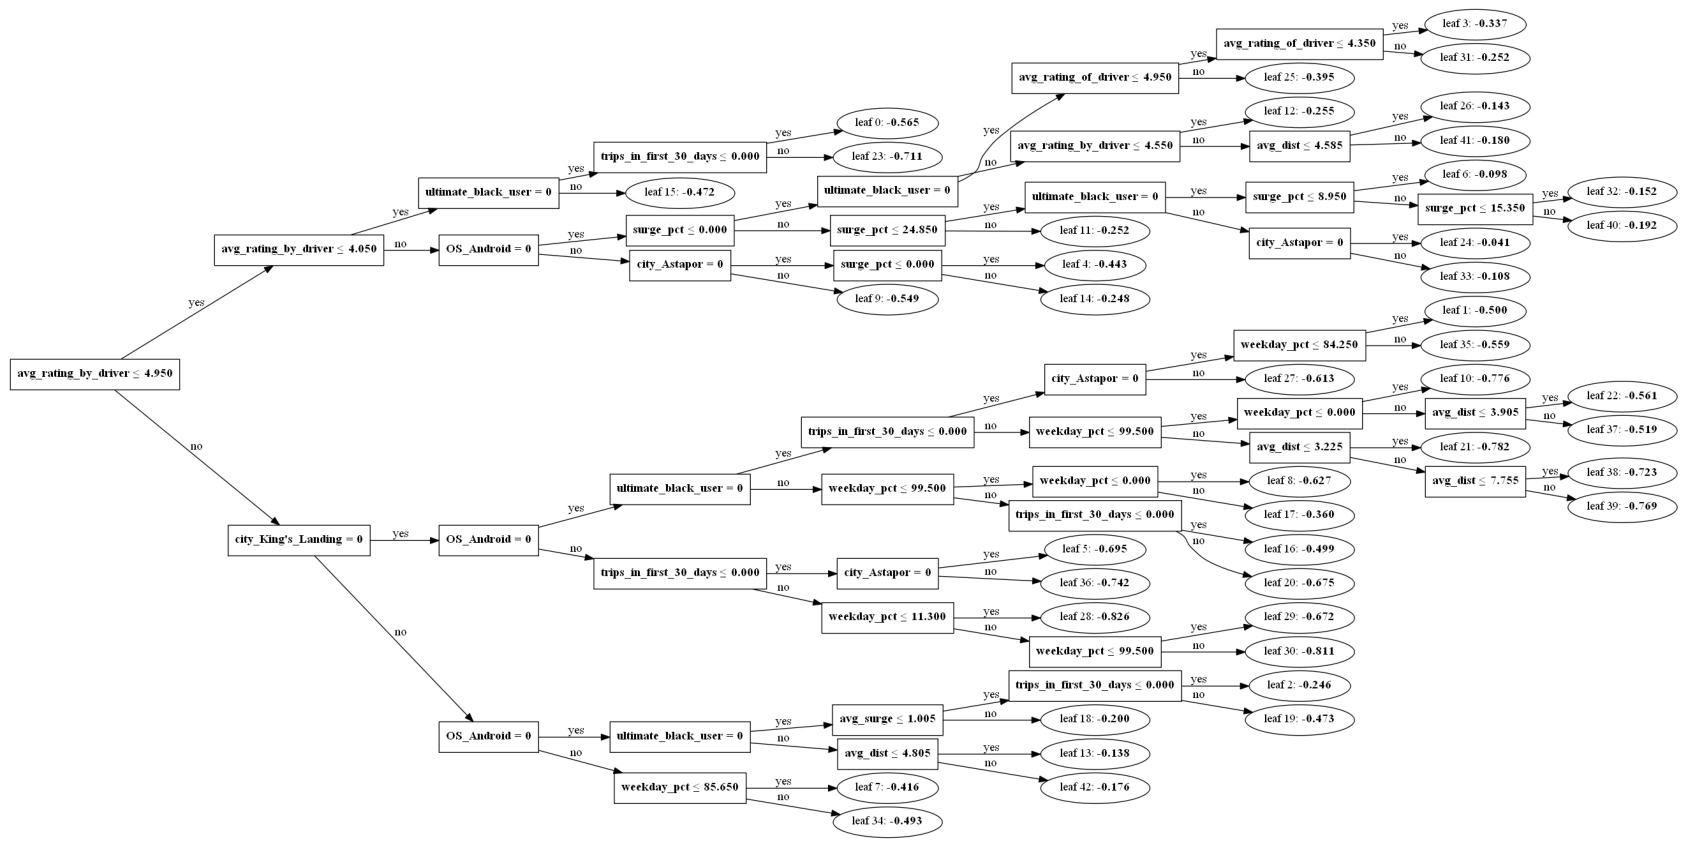

In [107]:
fig = lgbm.plot_tree(lgclf, figsize=(30,30))
fig.figure.savefig("decision_tree.png")